Short notebook to demonstrate interferogram formation for blackbody and wavecal files.
Files are taken from the tircis instrument back in 20180924.
Directory on mercury /home/harold/workdir/tircis/phot_20180924.

In [1]:
# for python 3 running of this notebook, 
# install numpy matplotlib jupyter jupyterlab ipywidgets

In [15]:
# vital imports
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import FloatSlider, interact, Label
from c_hyti_proc import *

%matplotlib inline

In [16]:
# edit below for your own setup
datadir='/Users/hg/workdir/hyti_proc_notebook/data/'
# get characteristics of instrument
nsamps=324
nlines=256
nbands=100
chyti = c_hyti_proc(nsamps,nlines)
print(chyti.nsamps)

324


In [17]:
### blackbody and wavecal definition
# hot and cold blackbodies although 60C is not really cold
bb90=datadir+'TIR-180924120627-bb90-scan.bsqmn'
bb60=datadir+'TIR-180924125013-bb60-scan.bsqmn'
# wavecals 
wc_9724=datadir+'wc_9724'

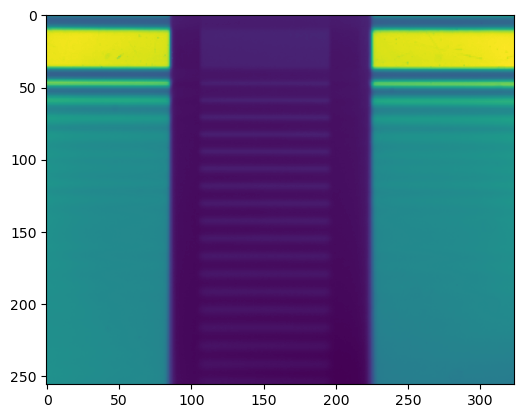

In [18]:
# get the flattened frame from each of the bb and wavecal file
bb90_flat=chyti.extract_flatten(bb90)
bb60_flat=chyti.extract_flatten(bb60)
wc_9724_flat=chyti.extract_flatten(wc_9724)

plt.imshow(wc_9724_flat)
plt.show()

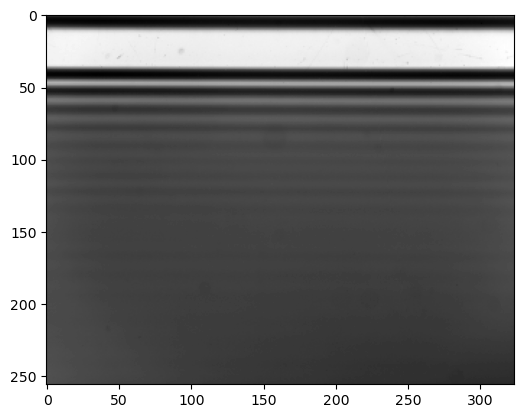

In [6]:
# display the image, noting the contact region at the top and fringes progressing from
# relatively sharp near contact region and fading as you progress away (towards bottom).
plt.imshow(bb90_flat,cmap='gray')

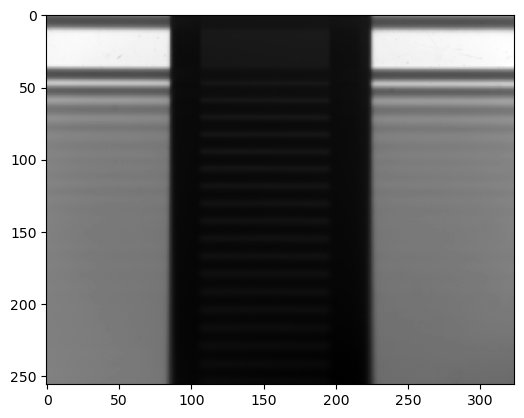

In [7]:
# display the 9.724 um wavecal. Note that the wavecal portion is in the central region of the array 
# due to imaging and target geometries. 

plt.imshow(wc_9724_flat,cmap='gray')

We are getting a half interferogram, as we are focusing on one side of the contact region. We 
can construct a full interferogram by selecting the contact region and samples to the right on the profile.
We can then reverse the array and join the two together to form an interferogram. Assume the contact region is at pixel 35. We will only take 200 pixels to the right. See below.

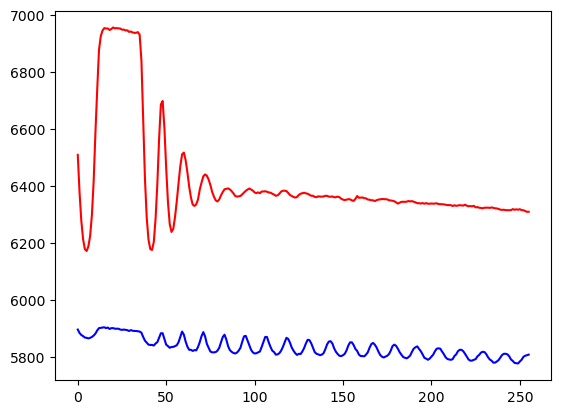

In [8]:
# plot profiles from both datasets (extract column 160)
bb90_prof=bb90_flat[:,160]
bb60_prof=bb60_flat[:,160]
wc_9724_prof=wc_9724_flat[:,160]
plt.plot(bb90_prof,'r') #plt bb90 in red
plt.plot(wc_9724_prof,'b') # wavecal in green
plt.show()

# note the difference in the fringes, with the wavecal being tight regular fringes which remain 
# strong throughout the array. This is due to the narrow bandpass of the wavecal giving a very tight 
# frequency response. 
# Also note the plateau from pixel ~10-35. This is the contact region.
# We are getting a half interferogram, as we are focusing on one side of the contact region. We 
# can constr

#### procedure to form interferogram 
1) Select out 200 pt segment at starting at contact region boundary
2) Mirror the segment to get 400 pt array
3) Zero mean
4) Apodize with triangular function
5) FFT 
### 

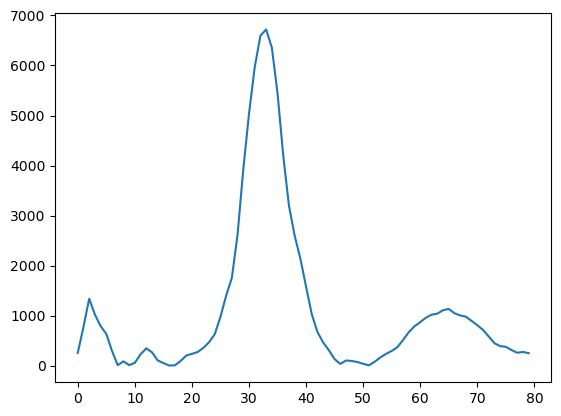

In [9]:
# create fcn to generate interferogram then fft mag and output the result

# try this for bb90
fftmag = chyti.proc_tircis(bb90_prof,36)
plt.plot(fftmag[0:80])
plt.show()

The above is a good result. But it may not be the best possible result.
We need to iterate through the contact region boundary zone to check for the best starting point.
For some camera wedge operations, an integer pixel stepsize to iterate is fine, but normally its best 
to do a subpixel interpolation and iterate at 1/4 or 1/8 pixel increments. 

In [10]:
# create a second function to subpixel interpolate the fcn by factor of 8

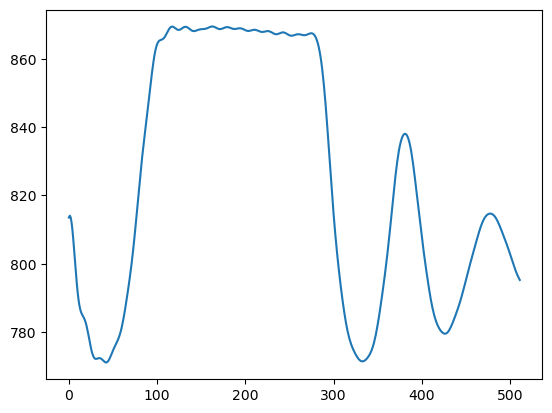

In [11]:


bigarr90= chyti.sp_interpolate(bb90_prof,8)
plt.plot(bigarr90[0:512])


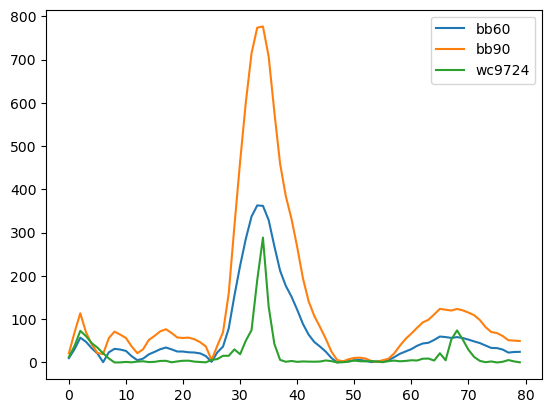

In [12]:
# The procedure then requires two steps after reading in the arrays
# extract the array that you want then 
# process with proc_tircis, but note in proc_tircis the starting point is zero, since we
# extracted at the desired starting point
bigarr90= chyti.sp_interpolate(bb90_prof,8)
bigarr60=chyti.sp_interpolate(bb60_prof,8)
big_wc_9724=chyti.sp_interpolate(wc_9724_prof,8)


newarr90=chyti.extract(bigarr90,8,36.5,200)
fftmag90 = chyti.proc_tircis(newarr90,0)
newarr60=chyti.extract(bigarr60,8,36.5,200)
fftmag60 = chyti.proc_tircis(newarr60,0)
newarrwc=chyti.extract(big_wc_9724,8,36.5,200)
fftmagwc=chyti.proc_tircis(newarrwc,0)
plt.plot(fftmag60[0:80],label="bb60")
plt.plot(fftmag90[0:80],label="bb90")
plt.plot(fftmagwc[0:80],label="wc9724")
plt.legend()

plt.show()

On the plot above, the region from pixel 28 to 45 would approximately correspond
to 12um to 8um. The peak of the wavecal plot shows that 9.724um approximately corresponds to bin
34 of the fft mag result.

Using the slider in the cell below allows for interactive visualization of the effect of modifying the starting location of the segment. Looking at the shape of the blackbodies and the wavecals, you can see that the optimal selection is in
the range of 36.4 to 36.7. Adding in one or two other wavecals can assist in nailing down this determination.


In [14]:
# Modify start position via the slider and observe the effects on the fft mag results for the blackbodies 
# and wavecals.


def update_fftmag(starts):
    newarr90=chyti.extract(bigarr90,8,starts,200)
    fftmag90 = chyti.proc_tircis(newarr90,0)
    newarr60=chyti.extract(bigarr60,8,starts,200)
    fftmag60 = chyti.proc_tircis(newarr60,0)
    newarrwc=chyti.extract(big_wc_9724,8,starts,200)
    fftmagwc=chyti.proc_tircis(newarrwc,0)
    plt.plot(fftmag60[0:80],label="bb60")
    plt.plot(fftmag90[0:80],label="bb90")
    plt.plot(fftmagwc[0:80],label="wc9724")
    plt.xlabel('FFT Bin')
    plt.ylabel('Magnitude')
    plt.legend()

    plt.show()


interact(update_fftmag, starts=FloatSlider(min=35.0, max=38.0, step=.1, value=36, 
    description="Start Loc"));

interactive(children=(FloatSlider(value=36.0, description='Start Loc', max=38.0, min=35.0), Output()), _dom_cl…